In [1]:
import sys
import importlib
import optax
import torch
import dill as pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import scipy.sparse as sps
import gc
import jax
import jax.numpy as jnp
A=jnp.linspace(0,2,2)
print(A)
from jax import grad, jit, vmap
import numba
import multiprocessing as mp
import sklearn as sk
from sklearn.decomposition import PCA
import dask
import scipy
from os.path import join
import os
sys.path.insert(1,'/your path here/')
import VPM as VPM
import MB_Model 




[0. 2.]
here3


First we will compute the committor for the Muller-Brown potential using a 2-D subspace iteration.
We first sample the short trajectories, then compute the grid-based reference solution for comparison, and then
we train the subspace.

In [ ]:
tau=1500
tau_net=tau
stride=1
N=50000
dt=.001
beta=2.0
n_mem=2
Delta=int((tau)/(n_mem+2)-1)
Deep=True
Xs=MB_Model.Sample_Starts(N,vmax=12)
Integrator_Params=[dt,beta,stride,tau+1,Deep]
ps=[]
for x in Xs:
    ps.append([x]+Integrator_Params)
Trajs=MB_Model.Integrator(ps)
Data=[]
for t in Trajs:
    Data.append(np.asarray(t[0:max(tau,tau_net)+1]))
Data=np.asarray(Data)[:,:,0:2]

ntraj=Data.shape[0]
lentraj=Data.shape[1]
InA=MB_Model.ellipseA(Data)
InB=MB_Model.ellipseB(Data)
Dts=VPM.MakeStopTimes(1-InB-InA,tau)
RHS=np.zeros((Data.shape[0],n_mem+3))
Data_stop=np.zeros((Data.shape[0],n_mem+3,Data.shape[-1]))
InA_stop=np.zeros((Data.shape[0],n_mem+3))
InB_stop=np.zeros((Data.shape[0],n_mem+3))
Data_stop[:,0]=Data[:,0]
InA_stop[:,0]=InA[:,0]
InB_stop[:,0]=InB[:,0]
for i in range(1,n_mem+2):
    Data_stop[:,i]=Data[np.arange(len(Data)),np.minimum(Dts[:,0],i*Delta)]
    InA_stop[:,i]=InA[np.arange(len(Data)),np.minimum(Dts[:,0],i*Delta)]
    InB_stop[:,i]=InB[np.arange(len(Data)),np.minimum(Dts[:,0],i*Delta)]
    RHS[:,i]=0*np.minimum(Dts[:,0],i*Delta)#*(1-InB_stop[:,0])

Data_stop[:,-1]=Data[np.arange(len(Data)),np.minimum(Dts[:,0],tau_net)]
InA_stop[:,-1]=InA[np.arange(len(Data)),np.minimum(Dts[:,0],tau_net)]
InB_stop[:,-1]=InB[np.arange(len(Data)),np.minimum(Dts[:,0],tau_net)]
RHS[:,-1]=0*np.minimum(Dts[:,0],tau_net)#*(1-InB_stop[:,0])
InD_stop=InB_stop+InA_stop


In [27]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def Identity(x):
    return x

QRef,DGrid_Reshape,InA_Reshape,InB_Reshape,L=MB_Model.Ref_Q(MB_Model.V,MB_Model.ellipseA,
                                                    MB_Model.ellipseB,beta=2.,res=100,
                                                      xrange=[-1.5,1],yrange=[-.5,2],Deep=True)

DGrid=DGrid_Reshape[:,None,:]
InAGrid=InA_Reshape[:,None]
InBGrid=InB_Reshape[:,None]
InDGrid=InAGrid+InBGrid

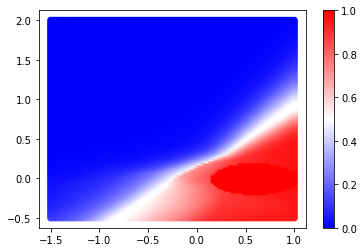

[1.         0.53638521]


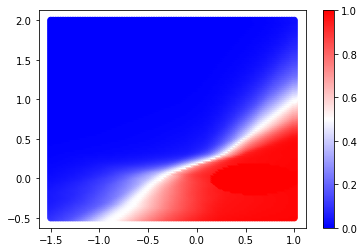

[1.        0.7322882]


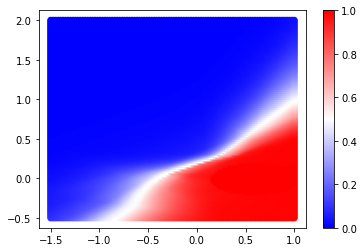

[1.         0.76999854]


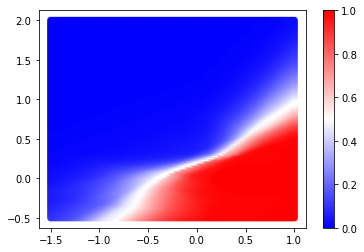

[1.        0.8021637]


In [30]:
k=2 #subspace dimension
Nets_List=[VPM.FF_ZBC,VPM.FF_Forecast_Subspace]
LossdJac=VPM.Loss_Jacobi_Sigd
Lossd=VPM.Loss_Subspace_Forecastd
dphi_star_List=[sigmoid,Identity] #We will use the softplus loss for the richardson iterate, so the first net
#gets passed through a sigmoid to give the result.
phi_t=np.concatenate([InB_stop[:,:,None],1-InD_stop[:,:,None]],axis=-1) #Initial guess for subspace
layer_sizes0 =[2,64,64,64,1]
layer_sizes1 =[2,64,64,64,k-1]
params_List=[]
params = VPM.init_network_params(layer_sizes0, jax.random.PRNGKey(0),scale=.01)
params_List.append(params)

params = VPM.init_network_params(layer_sizes1, jax.random.PRNGKey(0),scale=.01)
params.append(np.zeros(k-1))
params.append(np.eye(k))
params_List.append(params)

guess=np.zeros_like(phi_t)
guess[:,:,0]=-50*InA_stop+50*InB_stop #sigmoid of this functions satisfies (nearly) the committor boundary conditions
InD_stop=InA_stop+InB_stop
phi_t=np.ones((Data_stop.shape[0],Data_stop.shape[1],k))
phi_t[:,:,1]=phi_t[...,1]*(1-InD_stop)
phi_t[:,:,0]=InB_stop
guessGrid=np.zeros((DGrid.shape[0],1,k))
guessGrid[:,:,0]=-50*InAGrid+50*InBGrid

optimizer_List = [optax.adam(learning_rate=1e-3) for i in range(k)]
opt_state_List = [optimizer_List[i].init(params_List[i]) for i in range(k)]


for i in range(4):
    alpha=1/(i+1)**.5
    params_List,phi_t,opt_state_List,R=VPM.Subspace_Iteration_Forecast(params_List,
                         Data_stop,InD_stop,phi_t,guess,RHS,
                         optimizer_List,opt_state_List,Inner_Iter=5000,alpha=alpha,BS=2000,ls=None,
                         l2=.0,Orthogonalize=False,
                         Nets_List=Nets_List,LossdJac=LossdJac,Lossd=Lossd,dphi_star_List=dphi_star_List,
                         Update_K=0,Basis=False,Mem=False,n_QR_skip=0,Train_Frac=1.0)
    
    vec_t=VPM.Mem_Forecast(phi_t[:,0:-1,1:]*(1-InD_stop)[:,0:-1][:,:,None],RHS[:,0:-1],phi_t[:,:-1,0])

    vec_t=np.concatenate([[1]+list(vec_t)])
    F=np.concatenate([dphi_star_List[0](Nets_List[0](DGrid,InDGrid,params_List[0])+guessGrid[:,:,0])[:,:,None],
                      dphi_star_List[1](Nets_List[1](DGrid,InDGrid,params_List[1]))],axis=-1)
    
    Qgrid=F@vec_t
    plt.scatter(DGrid[:,0,0],DGrid[:,0,1],c=F[:,:,0],cmap='bwr')
    plt.colorbar()
    plt.show()
    print(vec_t)
    

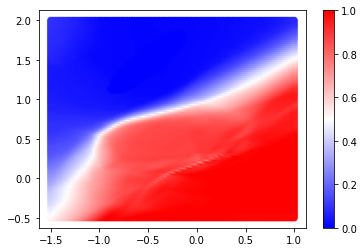

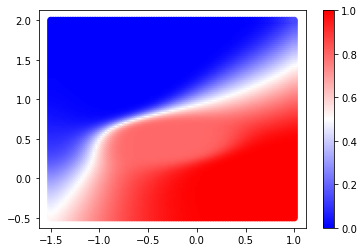

In [32]:
plt.scatter(DGrid[:,0,0],DGrid[:,0,1],c=np.clip(Qgrid[:,0],0,1),cmap='bwr')
plt.colorbar()
plt.show()
plt.scatter(DGrid[:,0,0],DGrid[:,0,1],c=QRef,cmap='bwr')
plt.colorbar()
plt.show()


Here is the same workflow for the Muller-Brown MFPT.

In [72]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def Identity(x):
    return x

MFPTref,DGrid_Reshape,InA_Reshape,InB_Reshape,L=MB_Model.Ref_MFPT(MB_Model.V,MB_Model.ellipseB,
                                                    MB_Model.ellipseB,beta=1.5,res=100,
                                                      xrange=[-1.5,1],yrange=[-.5,2],Deep=True)
DGrid=DGrid_Reshape[:,None,:]
InAGrid=InA_Reshape[:,None]
InBGrid=InB_Reshape[:,None]
InDGrid=InBGrid

In [74]:
tau=1000
tau_net=tau
stride=1

N=50000
dt=.001
#We will turn down beta to make the problem a bit easier.

beta=1.5
n_mem=2
Delta=int((tau)/(n_mem+2)-1)

Deep=True

Xs=MB_Model.Sample_Starts(N,vmax=12)

Integrator_Params=[dt,beta,stride,tau+1,Deep]
ps=[]
for x in Xs:
    ps.append([x]+Integrator_Params)
Trajs=MB_Model.Integrator(ps)
Data=[]
for t in Trajs:
    Data.append(np.asarray(t[0:max(tau,tau_net)+1]))
Data=np.asarray(Data)[:,:,0:2]

ntraj=Data.shape[0]
lentraj=Data.shape[1]
InA=MB_Model.ellipseA(Data)
InB=MB_Model.ellipseB(Data)
Dts=VPM.MakeStopTimes(1-InB,tau)
RHS=np.zeros((Data.shape[0],n_mem+3))
Data_stop=np.zeros((Data.shape[0],n_mem+3,Data.shape[-1]))
InA_stop=np.zeros((Data.shape[0],n_mem+3))
InB_stop=np.zeros((Data.shape[0],n_mem+3))
Data_stop[:,0]=Data[:,0]
InA_stop[:,0]=InA[:,0]
InB_stop[:,0]=InB[:,0]
for i in range(1,n_mem+2):
    Data_stop[:,i]=Data[np.arange(len(Data)),np.minimum(Dts[:,0],i*Delta)]
    InA_stop[:,i]=InA[np.arange(len(Data)),np.minimum(Dts[:,0],i*Delta)]
    InB_stop[:,i]=InB[np.arange(len(Data)),np.minimum(Dts[:,0],i*Delta)]
    RHS[:,i]=dt*np.minimum(Dts[:,0],i*Delta)

Data_stop[:,-1]=Data[np.arange(len(Data)),np.minimum(Dts[:,0],tau_net)]
InA_stop[:,-1]=InA[np.arange(len(Data)),np.minimum(Dts[:,0],tau_net)]
InB_stop[:,-1]=InB[np.arange(len(Data)),np.minimum(Dts[:,0],tau_net)]
RHS[:,-1]=dt*np.minimum(Dts[:,0],tau_net)
InD_stop=InB_stop



here3


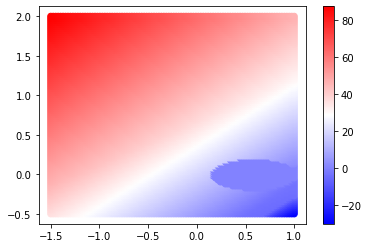

[ 45.83527185 105.70246138]


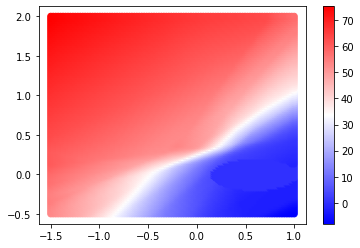

[30.7051857  -3.64532729]


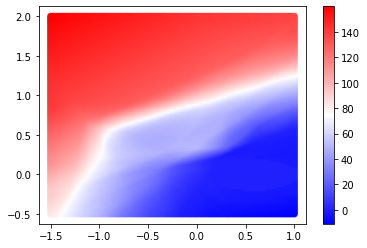

[37.03996433 11.46876197]


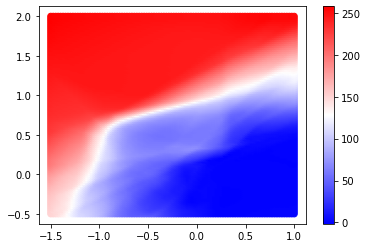

[47.9385848  16.91185651]


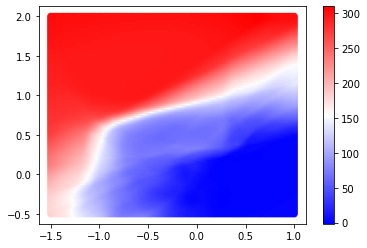

[45.8139398  16.18100153]


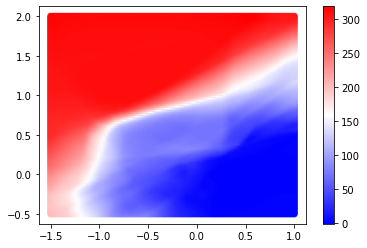

[41.2578307  13.96301234]


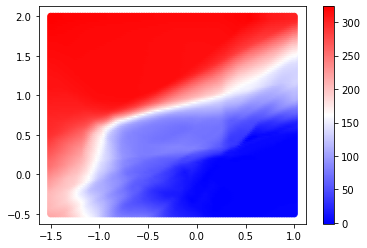

[36.23180508 11.82270165]


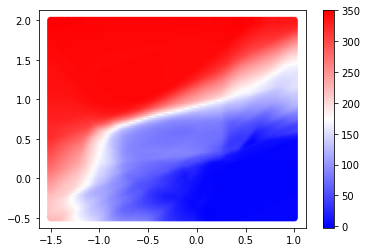

[35.1192093 11.0203003]


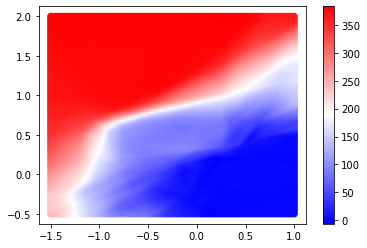

[34.36298071 10.37350856]


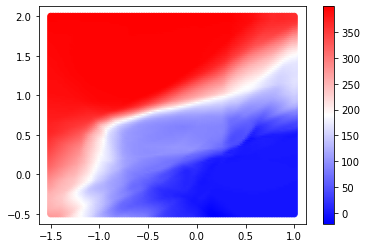

[32.16927612  9.49607174]


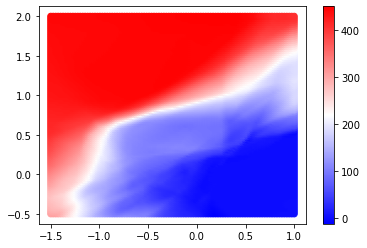

[33.10625113  9.77514043]


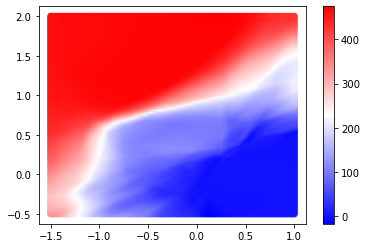

[32.07068227  9.306636  ]


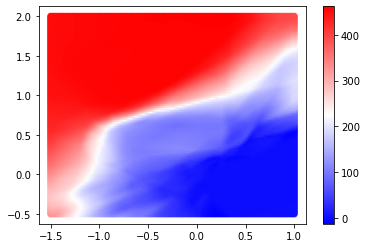

[29.3096426   8.28734309]


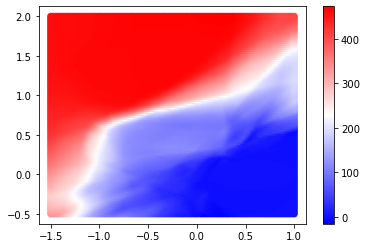

[28.16342385  7.5562918 ]


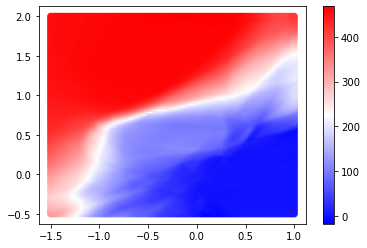

[26.19842739  6.66122174]


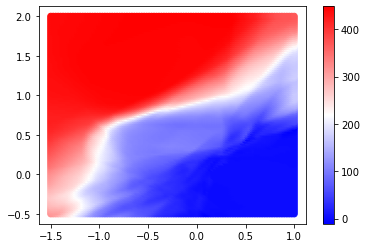

[23.95541409  5.89811298]


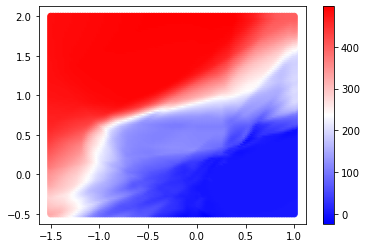

[24.92459111  5.83634422]


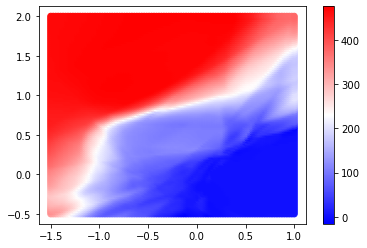

[22.59458416  5.21131481]


KeyboardInterrupt: 

In [77]:
importlib.reload(VPM)
k=2
Nets_List=[VPM.FF_ZBC,VPM.FF_Forecast_Subspace]
LossdJac=VPM.Loss_Jacobid
Lossd=VPM.Loss_Subspace_Forecastd
dphi_star_List=[Identity,Identity]
phi_t=np.concatenate([InB_stop[:,:,None],1-InD_stop[:,:,None]],axis=-1) #Initial guess for subspace

layer_sizes0 =[2,64,64,64,1]#Neural network architecture
layer_sizes1 =[2,64,64,64,k-1]
params_List=[]
params = VPM.init_network_params(layer_sizes0, jax.random.PRNGKey(0),scale=.01)
params_List.append(params)

params = VPM.init_network_params(layer_sizes1, jax.random.PRNGKey(0),scale=.01)
params.append(np.zeros(k-1))
params.append(np.eye(k))
params_List.append(params)

guess=np.zeros_like(phi_t)
guessGrid=np.zeros((DGrid.shape[0],1,k))


optimizer_List = [optax.adam(learning_rate=1e-3) for i in range(2)]
opt_state_List = [optimizer_List[i].init(params_List[i]) for i in range(2)]


for i in range(30):
    params_List,phi_t,opt_state_List,R=VPM.Subspace_Iteration_Forecast(params_List,
                         Data_stop,InD_stop,phi_t,guess,RHS,
                         optimizer_List,opt_state_List,Inner_Iter=5000,alpha=1.0,BS=2000,ls=None,l2=1,Orthogonalize=True,
                         Nets_List=Nets_List,LossdJac=LossdJac,Lossd=Lossd,dphi_star_List=dphi_star_List,
                         Update_K=1,Basis=False,Mem=False,n_QR_skip=0,Train_Frac=1.0)
    
    vec_t=VPM.Mem_Forecast(phi_t[:,0:-1,0:]*(1-InD_stop)[:,0:-1][:,:,None],RHS[:,0:-1],0*phi_t[:,:-1,0])
    F=np.concatenate([dphi_star_List[0](Nets_List[0](DGrid,InDGrid,params_List[0])+guessGrid[:,:,0])[:,:,None],
                      dphi_star_List[1](Nets_List[1](DGrid,InDGrid,params_List[1]))],axis=-1)
    
    #we orthogonalize for the zero BC problem here, so we need to multiply by R^-1
    Qgrid=F@np.linalg.inv(R)@vec_t
    plt.scatter(DGrid[:,0,0],DGrid[:,0,1],c=Qgrid[:,0],cmap='bwr')
    plt.colorbar()
    plt.show()
    print(vec_t)
    

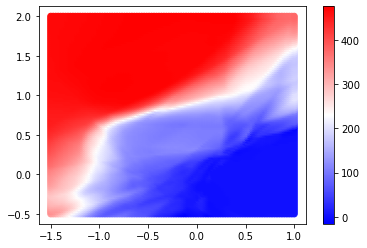

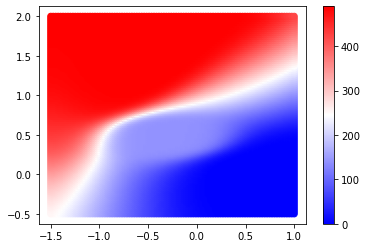

In [78]:
Becs=F@np.linalg.inv(R)
plt.scatter(DGrid[:,0,0],DGrid[:,0,1],c=Qgrid[:,0],cmap='bwr')
plt.colorbar()
plt.show()
plt.scatter(DGrid[:,0,0],DGrid[:,0,1],c=MFPTref,cmap='bwr')
plt.colorbar()
plt.show()


And again the workflow for the Muller-Brown invariant subspace.

In [22]:
def Initialize(Data,k):
    phi_t=np.concatenate([(Data@np.random.randn(Data.shape[-1]))[:,:,None] for i in range(k)],axis=-1)
    phi_t[:,:,0]=1
    Q,R=np.linalg.qr(phi_t[:,0])
    R=R/len(phi_t)
    return phi_t@np.linalg.inv(R)

def Subspace_Distance(X,Y):
    P_x=X@np.linalg.inv(X.T@X)@X.T
    P_y=Y@np.linalg.inv(Y.T@Y)@Y.T
    return np.real(np.sum(((np.eye(len(P_y))-P_y)@P_x)**2))**.5

valRef,vecRef,DGrid_Reshape,L=MB_Model.Ref_Subspace(MB_Model.V,k=3,beta=2,res=100,
                                                      xrange=[-1.5,1],yrange=[-.5,2],Deep=False)
DGrid=DGrid_Reshape[:,None,:]

In [19]:
importlib.reload(MB_Model)
tau=300
tau_net=tau
stride=1
N=50000
dt=.001
beta=2.
Deep=False #We are using the easier Muller-Brown, in alignment with the tests in the paper.
Xs=MB_Model.Sample_Starts(N,vmax=12)
Integrator_Params=[dt,beta,stride,tau+1,Deep]
ps=[]
for x in Xs:
    ps.append([x]+Integrator_Params)
Trajs=MB_Model.Integrator(ps)
Data=[]
for t in Trajs:
    Data.append(np.asarray(t[0:max(tau,tau_net)+1]))
Data=np.asarray(Data)[:,:,0:2]
ntraj=Data.shape[0]
lentraj=Data.shape[1]
Data_tau=np.zeros((Data.shape[0],2,Data.shape[-1]))
Data_tau[:,0]=Data[:,0]
Data_tau[:,-1]=Data[:,tau_net]

here3


Eigenvalues= 
[1.        +0.j 0.93273742+0.j 0.45365706+0.j]
Subspace Distance = 0.5836840043963213


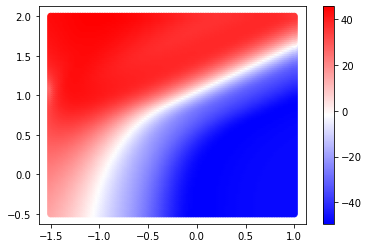

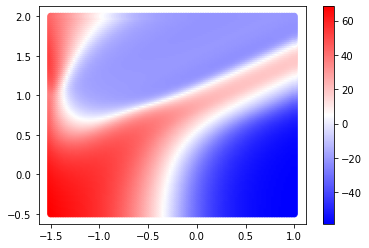

Eigenvalues= 
[1.        +0.j 0.98499881+0.j 0.61553985+0.j]
Subspace Distance = 0.3684629962799151


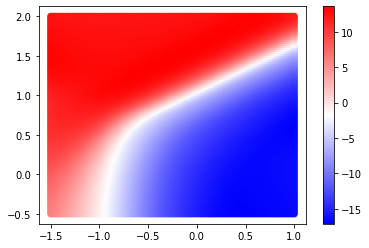

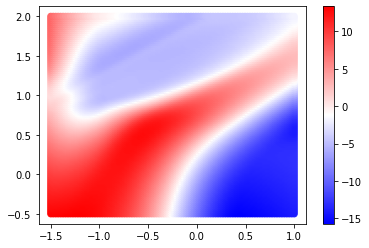

Eigenvalues= 
[1.       +0.j 0.9991512+0.j 0.6930275+0.j]
Subspace Distance = 0.2651422996318022


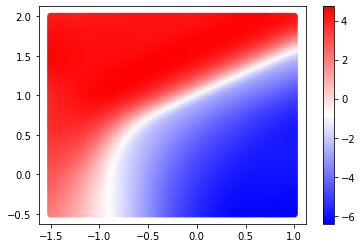

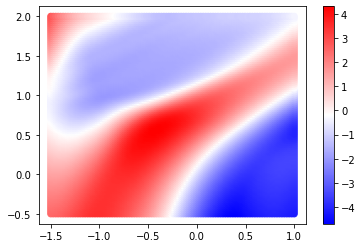

Eigenvalues= 
[1.        +0.j 1.00843171+0.j 0.69345819+0.j]
Subspace Distance = 0.2533767730035032


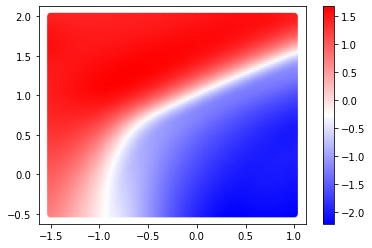

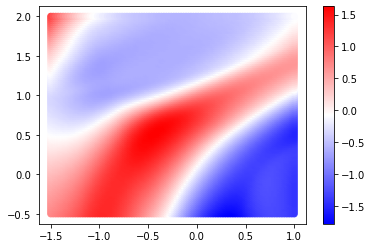

Eigenvalues= 
[1.        +0.j 0.99456539+0.j 0.69947139+0.j]
Subspace Distance = 0.25114062124929487


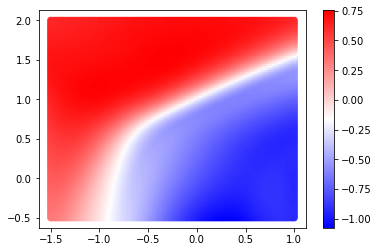

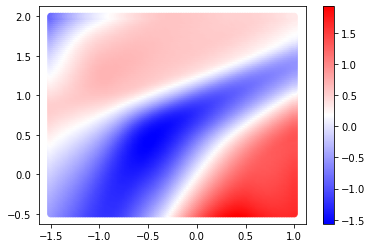

Eigenvalues= 
[1.        +0.j 0.99395971+0.j 0.69183136+0.j]
Subspace Distance = 0.2250308164748401


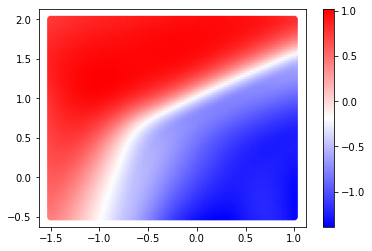

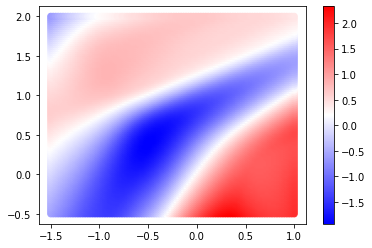

Eigenvalues= 
[1.        +0.j 1.00352989+0.j 0.69970311+0.j]
Subspace Distance = 0.2160499025423203


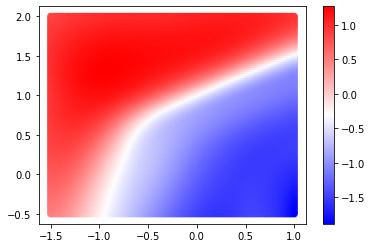

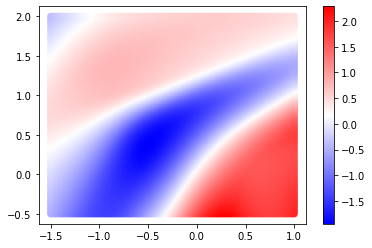

Eigenvalues= 
[1.        +0.j 0.99858049+0.j 0.70855411+0.j]
Subspace Distance = 0.21494643642266564


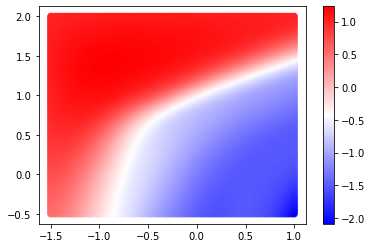

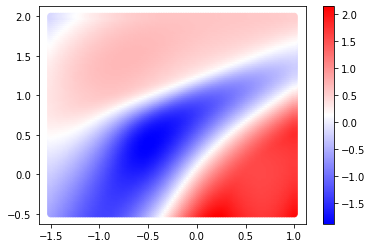

Eigenvalues= 
[1.        +0.j 0.99125668+0.j 0.71604775+0.j]
Subspace Distance = 0.1881330239487851


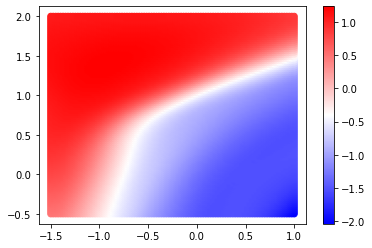

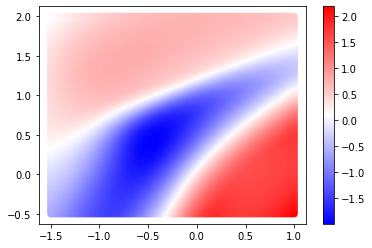

KeyboardInterrupt: 

In [25]:
importlib.reload(VPM)
k=3

phi_t=Initialize(Data_tau,k)
layer_sizes =[2,64,64,64,64,64,64,k-1] #only 2 functions are represented with the net.  The neural network will
#concatenate the constant function as its first output, since we know that this is an eigenfunction.  Thus the
#output of the net F=VPM.FF_Subspace(X,params) will have shape (X.shape[0],X.shape[1],k), with F[...,0]=1.

params = VPM.init_network_params(layer_sizes, jax.random.PRNGKey(0),scale=.01)
params.append(np.zeros(k))
params.append(np.eye(k))


optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(params)


for i in range(10):
    params,phi_t,opt_state,R=VPM.Subspace_Iteration(params,Data_tau,phi_t,
                     optimizer,opt_state,Inner_Iter=5000,alpha=1/((i+1)**.5),BS=2000,Lossd=VPM.Loss_Subspaced)
    
    val_t,vec_t=VPM.VAC(phi_t)
    print('Eigenvalues= ')
    print(val_t)
    F=VPM.FF_Subspace(DGrid,params)
    #we orthogonalize with the zero BC problem here, so we need to multiply by R^-1
    Eiggrid=F@np.linalg.inv(R)@vec_t
    sd=Subspace_Distance(np.array(Eiggrid)[:,0],vecRef) #The subspace distance is a measure of agreement between
    #the nets and the grid-based reference. For a k-dimensional subspace it falls in the range(0,k)
    print('Subspace Distance = '+str(sd))
    plt.scatter(DGrid[:,0,0],DGrid[:,0,1],c=Eiggrid[:,0,1],cmap='bwr')
    plt.colorbar()
    plt.show()
    plt.scatter(DGrid[:,0,0],DGrid[:,0,1],c=Eiggrid[:,0,2],cmap='bwr')
    plt.colorbar()
    plt.show()
    